# Aplicação de metodos de segunda ordem a fluxo de tráfico cúbico

Modelo de acordo com a lição 3 do módulo 3:

* $u^{\star}$: Velocidade de tráfego **ideal**
* $\rho^{\star}$ : densidade de tráfego **ideal**

\begin{equation}F_{\rm max} = \rho^{\star}u^{\star}\end{equation}
\begin{equation}F(\rho) = u_{\rm max}\rho (1 - A\rho - B \rho^2)\end{equation}

Para determinar as incógnitas $A$ and $B$, aplicamos as outras condições ao fluxo $F$ baseado agora nas quantidades $u^{\star}$ and $\rho^{\star}$:

*  Quando $\rho = \rho_{\rm max}$ o fluxo de tráfego vai para zero:

\begin{equation}F(\rho_{\rm max}) = 0 = u_{\rm max}\, \rho_{\rm max}(1 - A \rho_{\rm max} - B \rho_{\rm max}^2)\end{equation}

*  O fluxo máximo ocorre quando $\rho = \rho^{\star}$ e $F'(\rho^{\star}) = 0$:

\begin{equation}
F'(\rho^{\star}) = 0  = u_{\rm max}(1 - 2A\rho^{\star} - 3B(\rho^{\star})^2)\end{equation}

*  $u^{\star}$ é obtido quando $\rho = \rho^{\star}$:

\begin{equation}
u^{\star} = u_{\rm max}(1 - A \rho^{\star} - B(\rho^{\star})^2)\end{equation}

In [1]:
import sympy
sympy.init_printing()

# Sistema de equacoes a ser resolvido para A, B e rho_star
u_max, u_star, rho_max, rho_star, A, B = sympy.symbols('u_max u_star rho_max rho_star A B')
eq1 = sympy.Eq( 0, u_max*rho_max*(1 - A*rho_max-B*rho_max**2) )
eq2 = sympy.Eq( 0, u_max*(1 - 2*A*rho_star-3*B*rho_star**2) )
eq3 = sympy.Eq( u_star, u_max*(1 - A*rho_star - B*rho_star**2) )

In [2]:
eq1

In [3]:
eq2

In [4]:
eq3

In [5]:
# Combinando as equações 2 e 3 eliminamos B e armazenamos numa nova equação:
eq4 = sympy.Eq(eq2.lhs - 3*eq3.lhs, eq2.rhs - 3*eq3.rhs)
eq4.simplify()

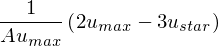

In [6]:
# Isolamos rho_star na variavel rho_sol:
rho_sol = sympy.solve(eq4,rho_star)[0]
rho_sol

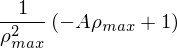

In [7]:
# Isolamos B de eq1 na variavel B_sol:
B_sol = sympy.solve(eq1,B)[0]
B_sol

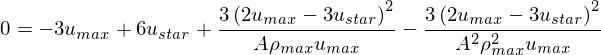

In [8]:
# Substituindo esses valores na eq2 obtem-se equacao quadratica em A:
quadA = eq2.subs([(rho_star, rho_sol), (B,B_sol)])
quadA.simplify()

In [9]:
# Resolvendo a equacao para A
A_sol = sympy.solve(quadA, A)

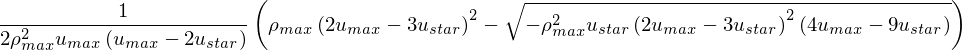

In [10]:
# Raiz 1
A_sol[0]

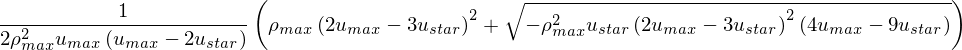

In [11]:
# Raiz 2
A_sol[1]

### Valores numéricos
\begin{align} 
\rho_{\rm max} &=10.0 \nonumber\\ u_{\rm max} &=1.0 \nonumber\\ u^{\star} &=0.7 \nonumber
\end{align}

In [12]:
aval = A_sol[0].evalf(subs={u_star: 0.7, u_max:1.0, rho_max:10.0} )
aval

In [13]:
# A raiz negativa nao sera usada
A_sol[1].evalf(subs={u_star: 0.7, u_max:1.0, rho_max:10.0} )

In [14]:
bval = B_sol.evalf(subs={rho_max:10.0, A:aval} )
bval

C:\Users\cacs\Anaconda3\lib\site-packages\ipykernel\__main__.py:50: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


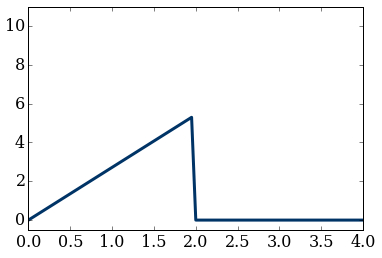

In [15]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

sympy.init_printing(use_latex=False) # turns off LaTeX printing

rho_max = 10.
u_max   = 1.

def computeF(u_max, rho, aval, bval):
    """Computes traffic flux F

    Parameters
    ----------
    u_max     : float
        Max traffic velocity
    rho       : float
        Density of cars
    aval      : float
        Value of A in terms of u_max, rho_max, u_star
    bval      : float
        Value of B in terms of u_max, rho_max, u_star

    Returns
    -------
    F         : float
        Traffic flux
    """    
    return u_max*rho*(1 - aval*rho-bval*rho**2)

def rho_green_light(nx, rho_light):
    """Computes "green light" initial condition with shock, and linear distribution behind

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_light : float
        Density of cars at stoplight

    Returns
    -------
    rho_initial: array of floats
        Array with initial values of density
    """    
    rho_initial = numpy.arange(nx)*2./nx*rho_light  # Before stoplight
    rho_initial[(nx-1)/2:] = 0
    
    return rho_initial

#Basic initial condition parameters
#defining grid size, time steps
nx = 81
nt = 30
dx = 4.0/(nx-1)

x = numpy.linspace(0,4,nx)

rho_light = 5.5
rho_initial = rho_green_light(nx, rho_light)

pyplot.plot(x, rho_initial, color='#003366', ls='-', lw=3)
pyplot.ylim(-0.5,11.);

In [16]:
def ftbs(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with forward in time, backward in space
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho))) 
    
    #copy the initial u array into each row of our new array
    rho_n[0,:] = rho.copy()              
    
    for t in range(1,nt):
        F = computeF(u_max, rho, aval, bval)
        rho_n[t,1:] = rho[1:] - dt/dx*(F[1:]-F[:-1])
        rho_n[t,0] = rho[0]   # C.C. a esquerda: mantem valor da C.I.
        rho_n[t,-1] = rho[-1] # C.C. a direita: mantem valor da C.I.
        rho = rho_n[t].copy()

    return rho_n

sigma = 1.
dt = sigma*dx/u_max

rho_n = ftbs(rho_initial, nt, dt, dx, rho_max, u_max)


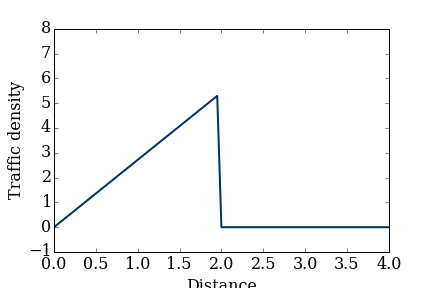
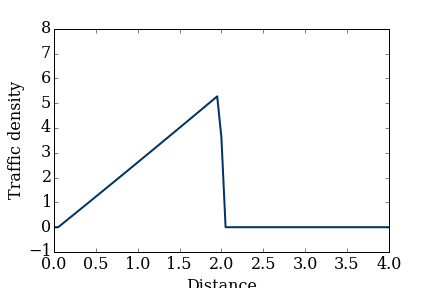
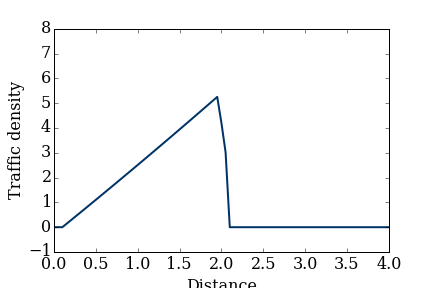
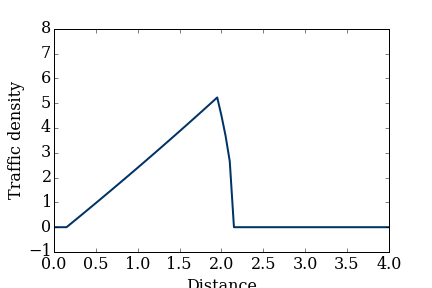
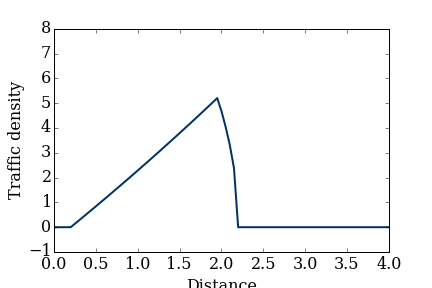
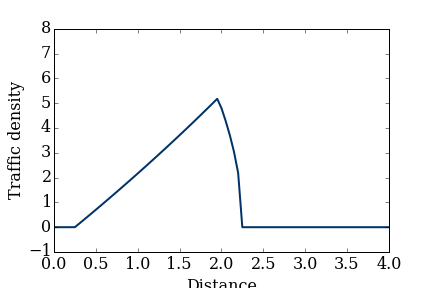
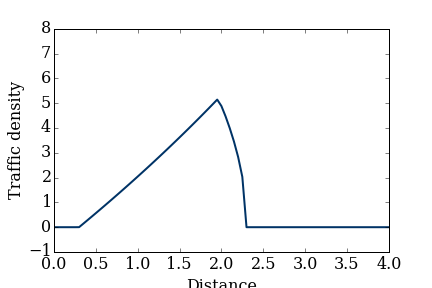
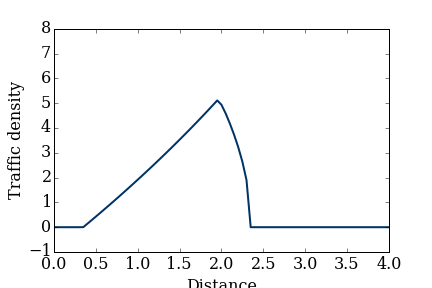
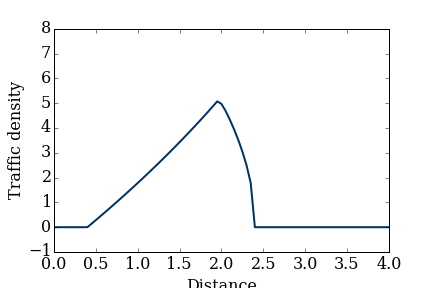
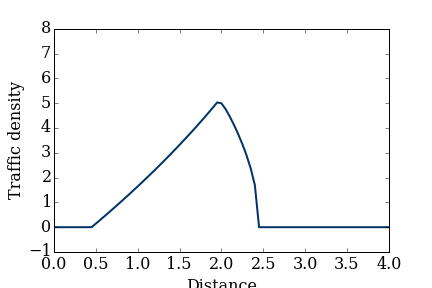
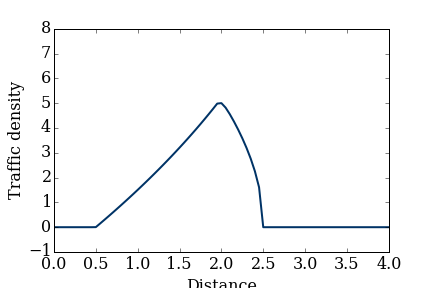
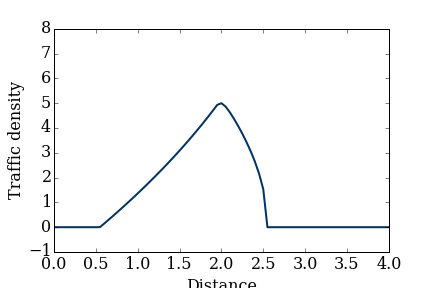
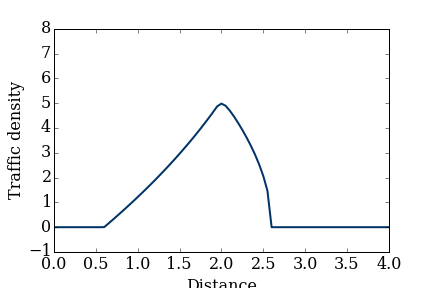
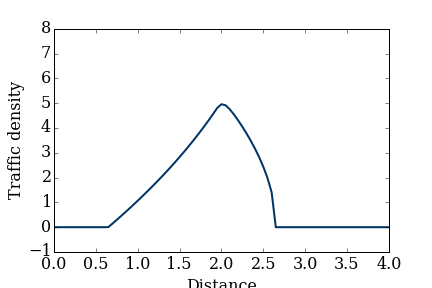
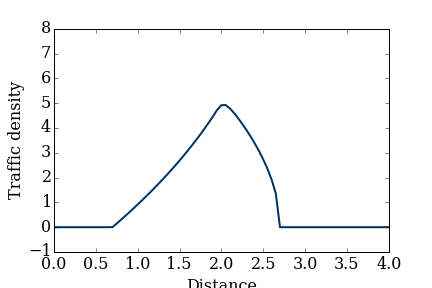
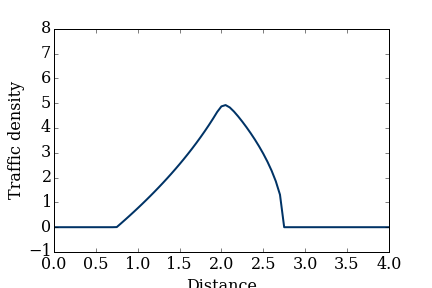
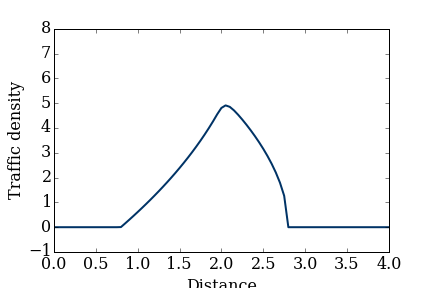
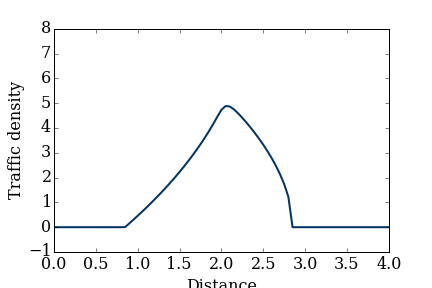
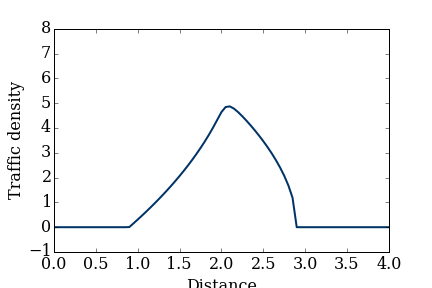
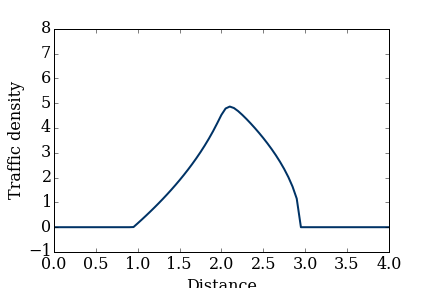
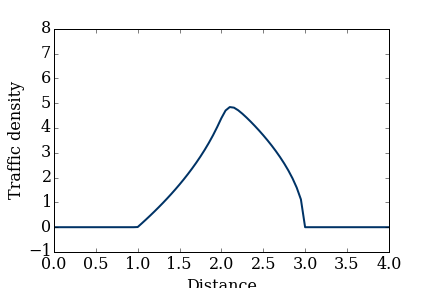
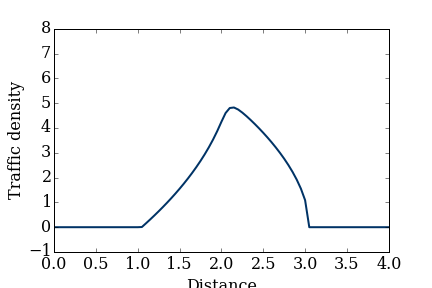
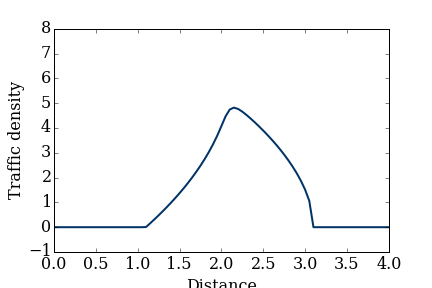
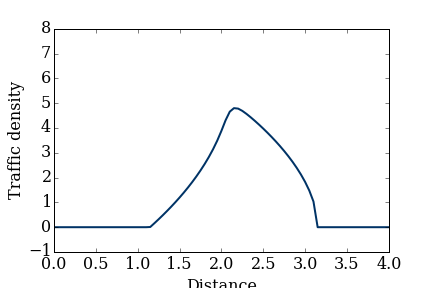
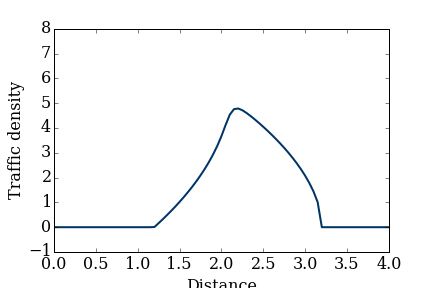
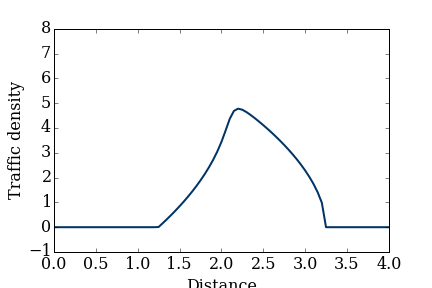
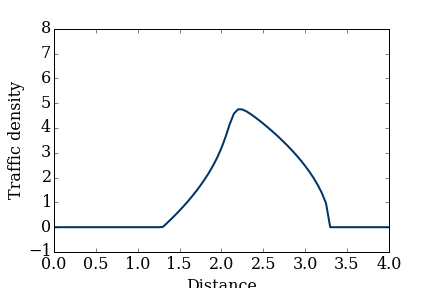
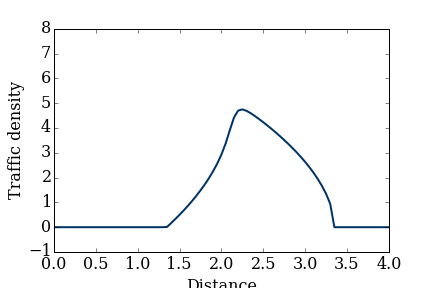
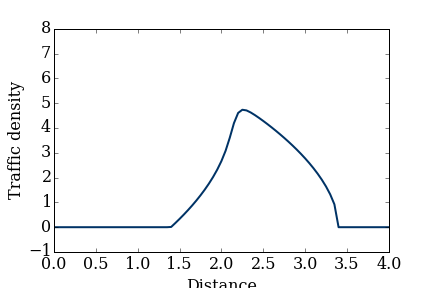
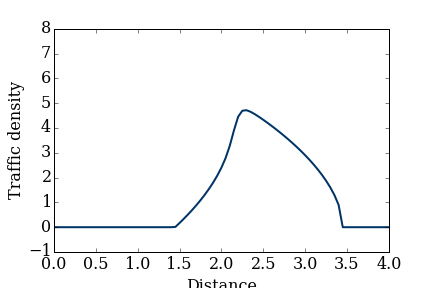

In [17]:
# Visualizacao do resultado
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(-1,8),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

In [19]:
def Jacobian(u_max, rho, aval, bval):
    return u_max*(1-2*aval*rho-3*bval*rho**2)

def laxwendroff(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with Lax-Wendroff scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    

    for t in range(1,nt):
        F = computeF(u_max, rho, aval, bval)
        J = Jacobian(u_max, rho, aval, bval)
        
        rho_n[t,1:-1] = rho[1:-1] - dt/(2*dx)*(F[2:]-F[:-2]) \
                           + dt**2/(4*dx**2) * ( (J[2:]+J[1:-1])*(F[2:]-F[1:-1]) \
                           - (J[1:-1]+J[:-2])*(F[1:-1]-F[:-2]) )
        
        rho_n[t,0] = rho[0]   # C.C. a esquerda: mantem valor da C.I.
        rho_n[t,-1] = rho[-1] # C.C. a direita: mantem valor da C.I.
        rho = rho_n[t].copy()
        
    return rho_n

rho_initial = rho_green_light(nx, rho_light)
sigma = 1.
dt = sigma*dx/u_max

rho_n = laxwendroff(rho_initial, nt, dt, dx, rho_max, u_max)

C:\Users\cacs\Anaconda3\lib\site-packages\ipykernel\__main__.py:50: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



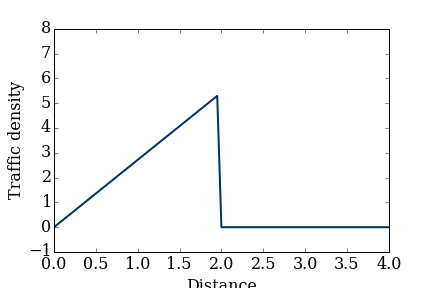
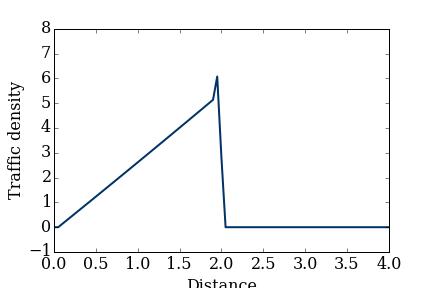
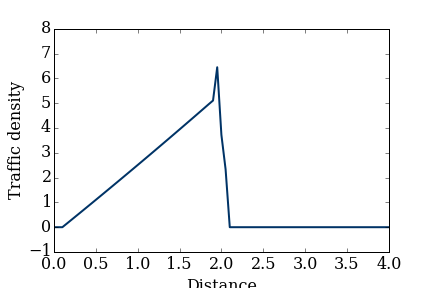
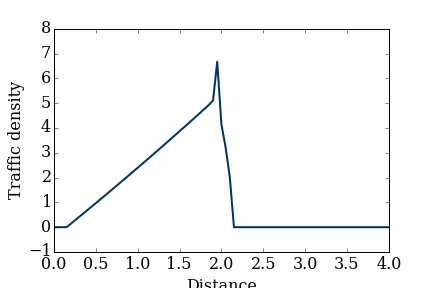
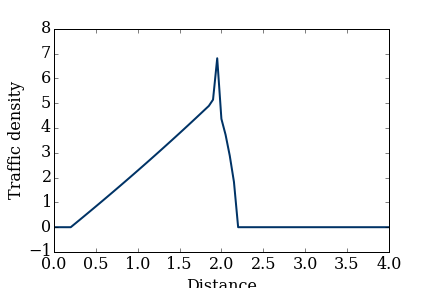
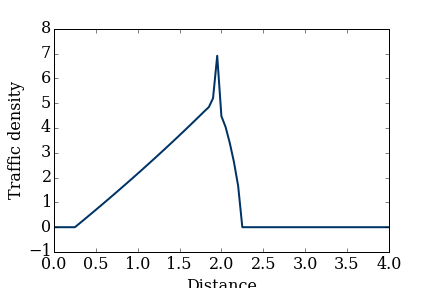
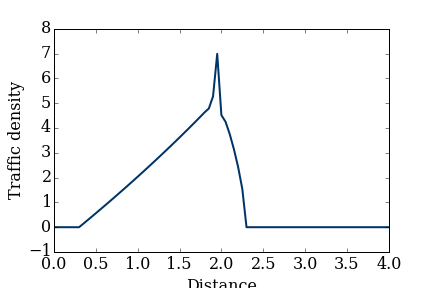
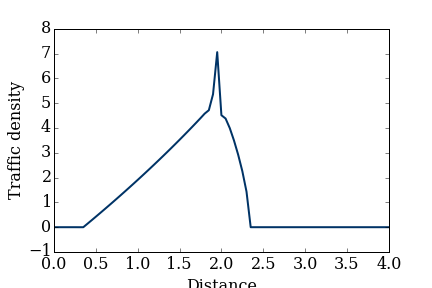
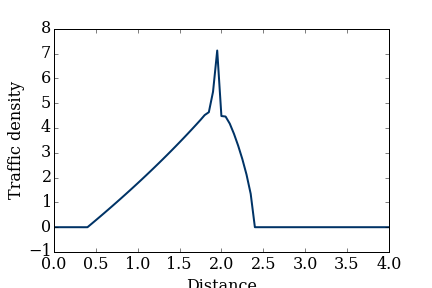
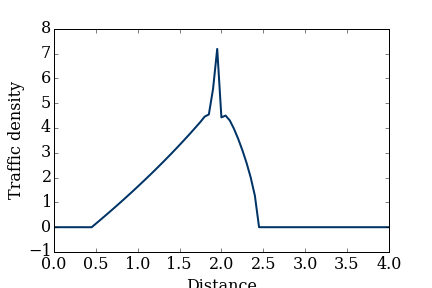
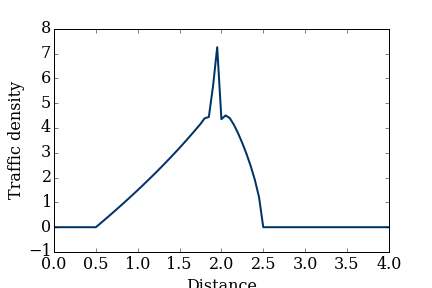
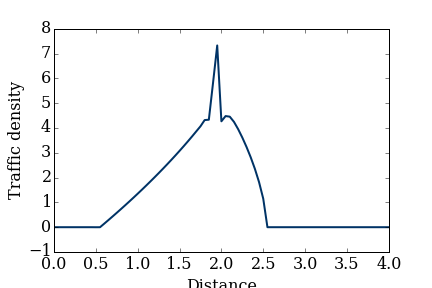
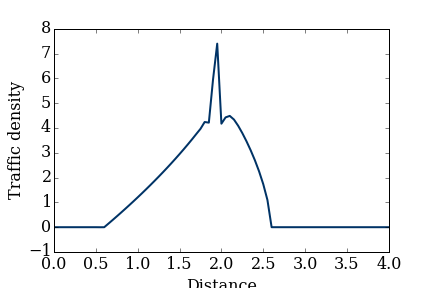
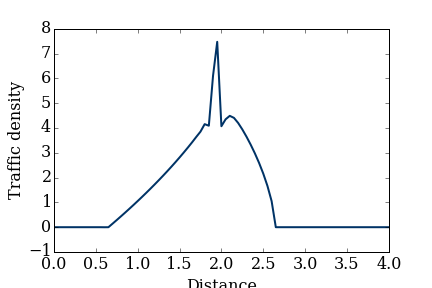
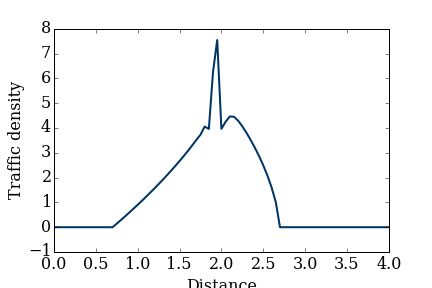
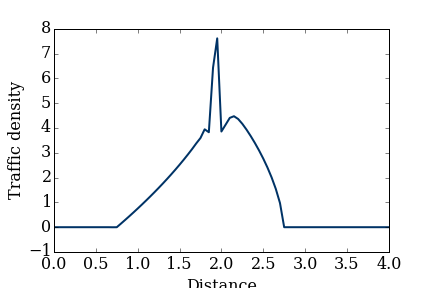
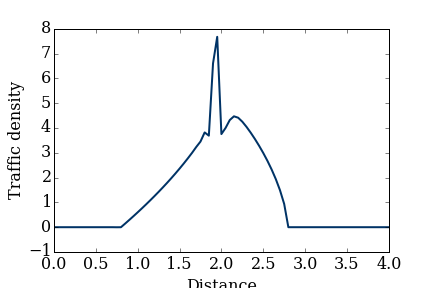
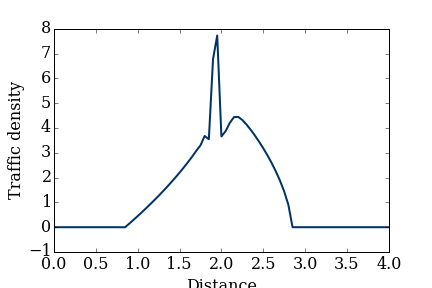
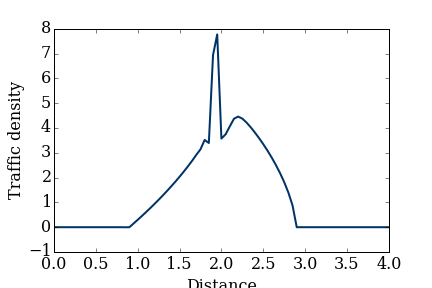
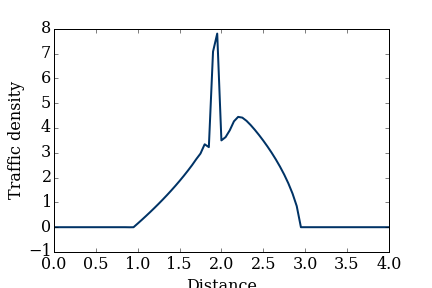
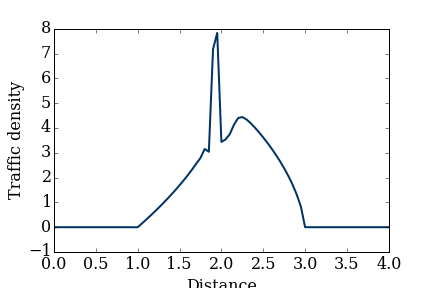
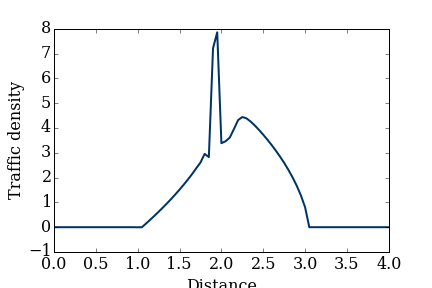
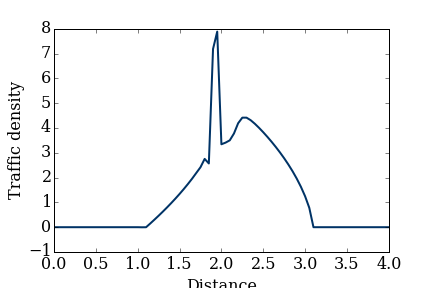
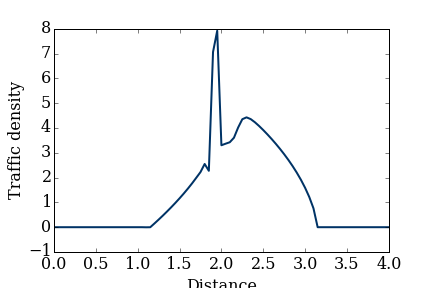
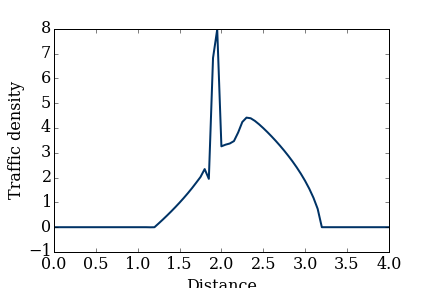
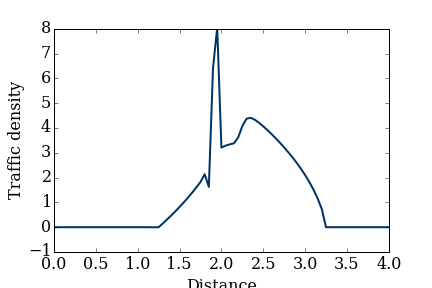
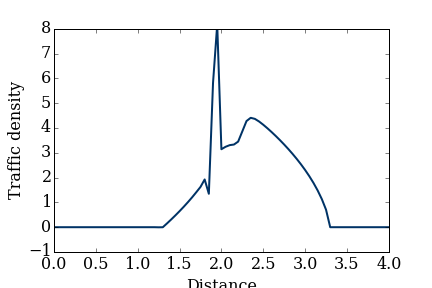
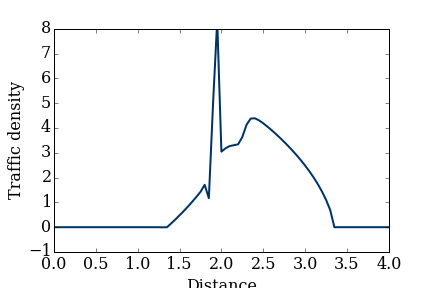
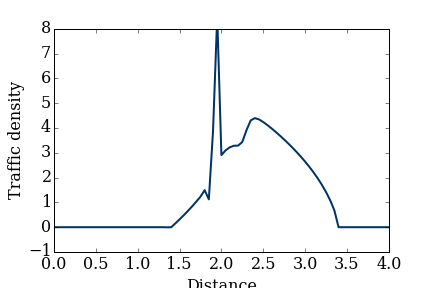
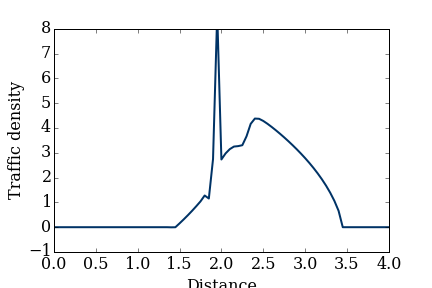

In [20]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

In [22]:
def maccormack(rho, nt, dt, dx, u_max, rho_max):
    """ Computes the solution with MacCormack scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    rho_n = numpy.zeros((nt,len(rho)))
    rho_star = numpy.empty_like(rho)
    rho_n[:,:] = rho.copy() # Ja coloca as C.C.s em todos os instantes
    rho_star = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho, aval, bval)
        rho_star[:-1] = rho[:-1] - dt/dx * (F[1:]-F[:-1])
        Fstar = computeF(u_max, rho_star, aval, bval)
        rho_n[t,1:] = .5 * (rho[1:]+rho_star[1:] - dt/dx * (Fstar[1:] - Fstar[:-1]))
        rho = rho_n[t].copy()
        
    return rho_n

rho_initial = rho_green_light(nx, rho_light)
sigma = 1.
dt = sigma*dx/u_max

rho_n = maccormack(rho_initial, nt, dt, dx, rho_max, u_max)

C:\Users\cacs\Anaconda3\lib\site-packages\ipykernel\__main__.py:50: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cacs\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: overflow encountered in square



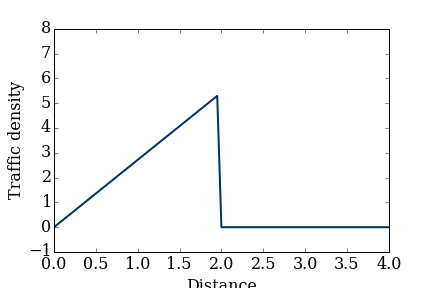
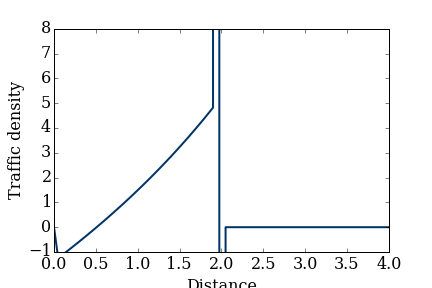
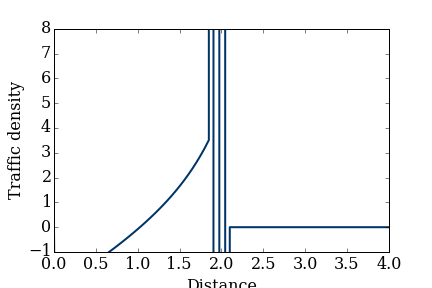
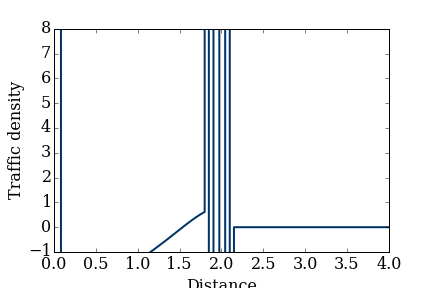
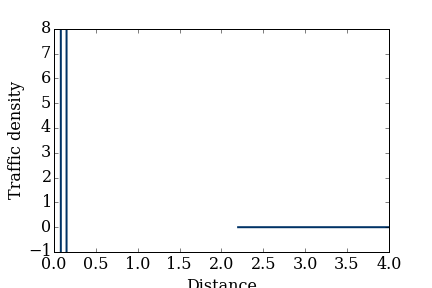
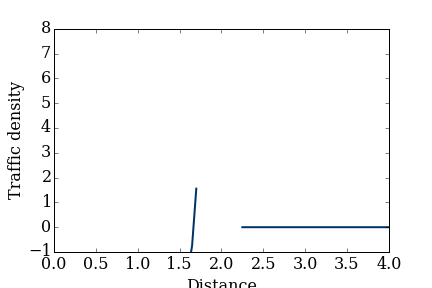
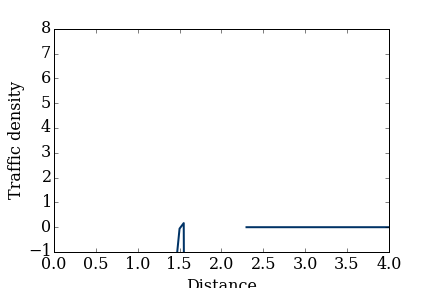
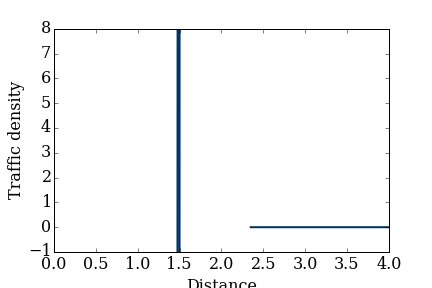
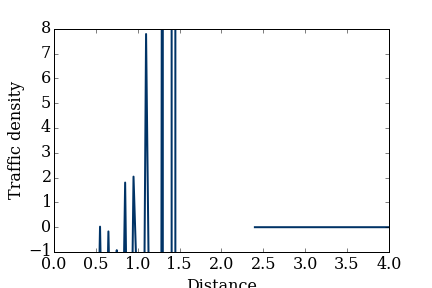
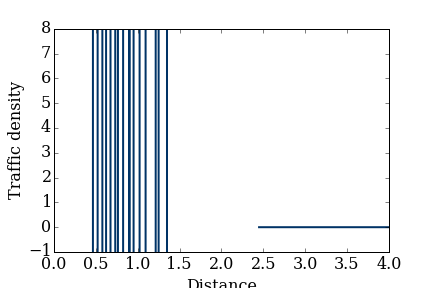
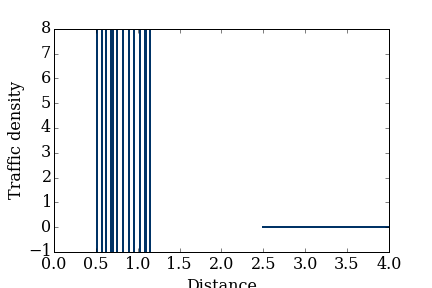
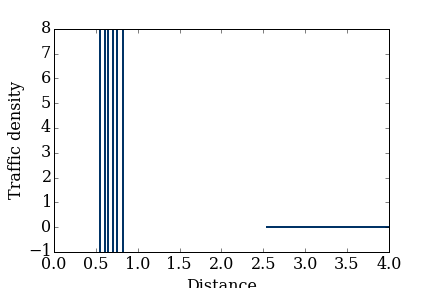
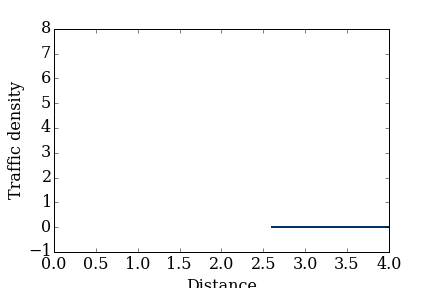
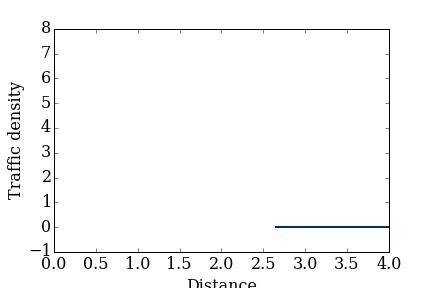
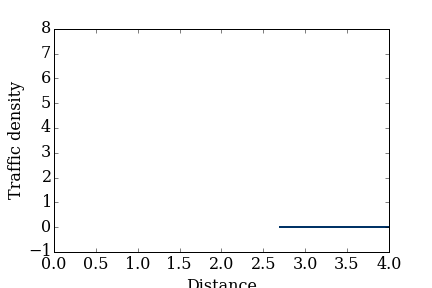
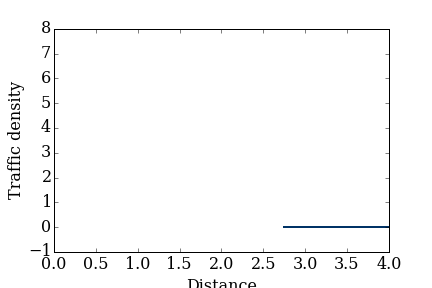
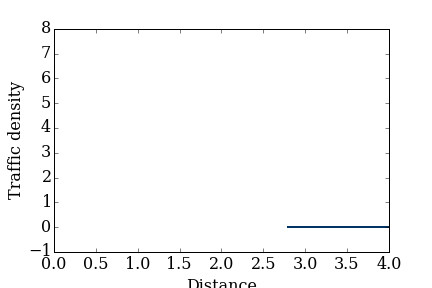
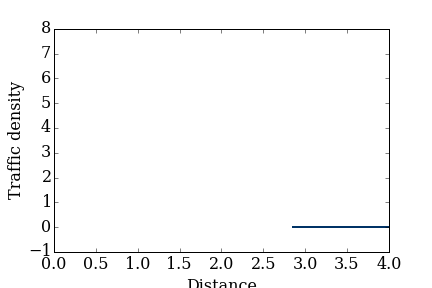
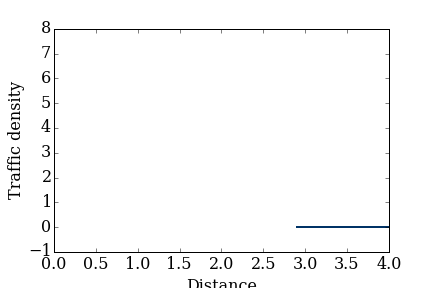
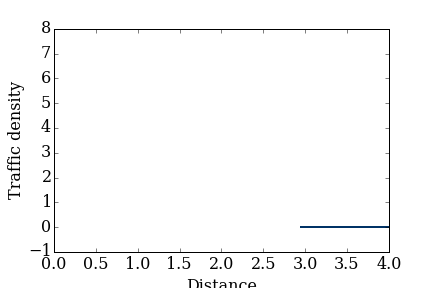
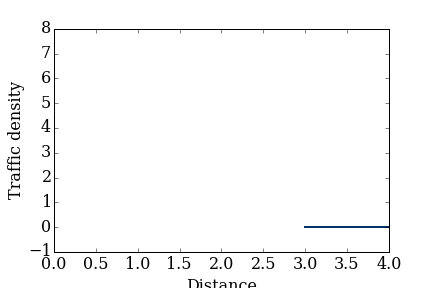
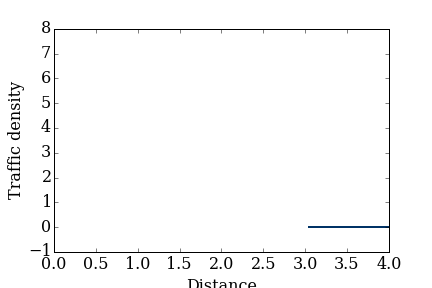
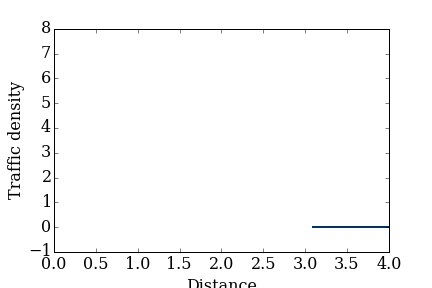
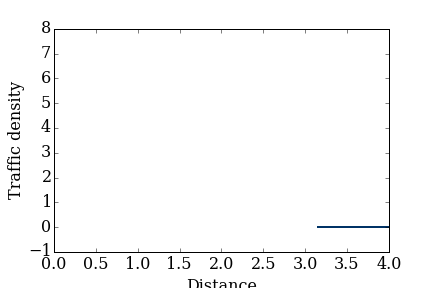
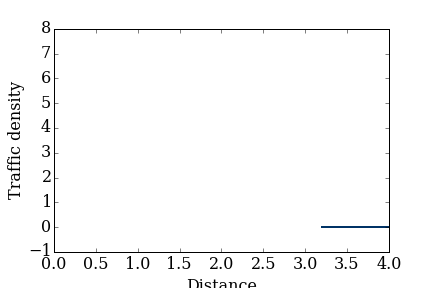
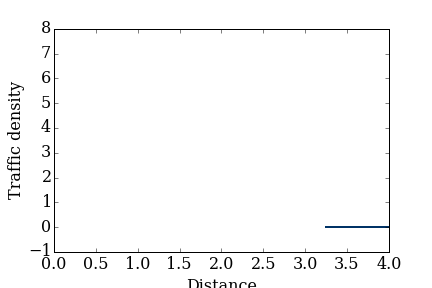
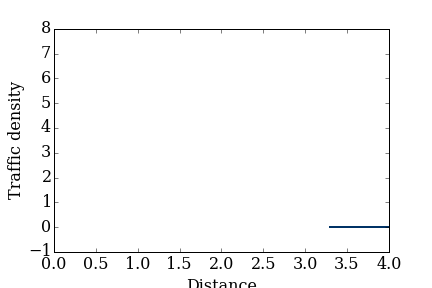
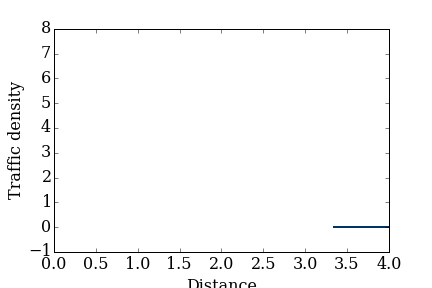
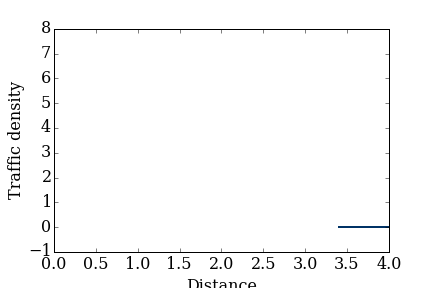
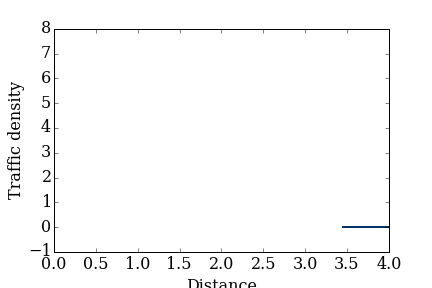

In [23]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')